In [1]:
from aggregate import aggregate
from aggregate import capm_params
from feature_handler import feature_handler
from run_model import regression_models
from run_model import discrete_models
from visualize import visualize
import pandas as pd
import numpy as np
import utils
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json
import pickle
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set()

# Data Science Workshop - Project notebook
### Predicting Abnormal Return of Stocks Around Dividend Announcements

**Anat Luckach, Dean Carmeli, Matan Carmon, Elad Ben Avraham**

## Introduction


Abnormal return (AR) is defined as the difference between the actual stock price and the expected stock price. To measure it, one needs a notion of how to evaluate the expected stock price of a given firm at a given day. A well published, commonly used model is the Capital Asset Pricing Model (CAPM) which determines linearity between the expected stock price and market portfolio. <br/>
We decided to implement the event study method, which is a commonly used method in evaluation theory and was also used in previous studies  . By this method, we need to create a time window around the announcement during which we would measure the AR. <br/>
Previous studies were mainly focused on the informative value of dividend announcements and hypothesis testing relating to that. Therefore, while their estimated parameters are statistically significant, they normally show rather low R^2 results (7.5% in Kothari, Shu, Wysocki).  
We aim to predict the abnormal return while reassuring or contradicting the underlying financial theory. To increase the predictive power of our model, we would need to re-visit the measurement assumptions. On top we would need to analyze our results considering relevant financial theory.
Our focal point therefore is a complex problem setting. We would also like to note we didn’t use a given data set from Kaggle, and therefore a lot of effort was dedicated to the integration process.
Since we believe the more interesting part is the analysis and results, our Notebook doesn’t reflect the complexity behind it.


## Step 0: Notebook Intialization
seed: 
>We ran the notebook using seed = 10

run_speed: The speed that the notebook will run
>3 - fastest (immediate, skip all non-immediate parts)<br/>
    2 - average (skip just the really long parts)<br/>
    1 - slowest (run all code)

In [3]:
seed = 10
run_speed = 2
random.seed(seed)
np.random.seed(seed)

## Step 1: data pre-process steps and initial feature extraction

#### Aggregation

We start from the file "all_prices.json" -  a json file with all prices and information about the divivdend annucments from NASDAQ and prices from "YAHOO! FINANCES".<br/>
The block below takes about 5 minutes, will run only when run_speed == 1 (slowest).

In [4]:
if run_speed <= 1:
    #utils.unzip_data() 
    all_prices = json.load(open("all_prices.json", "r"))

    # Step 1: Calculate alpha and beta parameters based on CAPM model
    data_with_capm = capm_params.get_data_with_capm_params(all_prices)

    # Step 2: Add sector and industry + change format from dict to DataFrame
    df = aggregate.aggregate_meta_data(data_with_capm)
    df = aggregate.fill_missing_meta_data(df)

    # Step 3: Split the date column to have year, month and quarter
    df = utils.split_date(df)

    # Step 4: Add financial ratios.
    # Drop samples from before 1998 (no financial ratios data)
    df.drop(df[df["year"] <= 1997].index, inplace=True)
    df = aggregate.aggregate_fin_ratios(df)
    df.drop(['dividend_date'], axis = 1, inplace = True)
else: 
    df = pd.read_csv("aggregated_data.csv")
df.drop(utils.drop_cols, axis = 1, inplace = True) #columns we didn't use in the project at all
df.reset_index(drop=True, inplace = True)

#### The Data

In [6]:
display(df.head(1))

,company_name,industry,sector,dividend_date,dividend_amount,alpha,beta,price_t-5,sp_price_t-5,price_t-4,...,year,month,quarter,MV Debt Ratio,BV Debt Ratio,Effective Tax Rate,Std Deviation In Prices,EBITDA/Value,Fixed Assets/BV of Capital,Capital Spending/BV of Capital
0,"American Airlines Group, Inc.",Air Freight/Delivery Services,Transportation,2019-10-22,$0.10,-33.847291,0.020567,27.93,2997.949951,28.219999,...,2019,10,4,0.229,0.558,0.084,0.385,0.1,0.319,0.047


In the data each sample is a specific dividend announcment of some company.
For each sample we have:
* **company_name , symbol**
* **sector , industry** - sector is more general, while industry is more specific
* **dividend_date** - the declaration date of the dividend.
* **dividend_amount** - the amount (in USD) of the dividend per share.
* **alpha, beta** - the coefficients of the CAPM (as calculated above) model (more on that in the PDF documentation)<br/>


* **price_t-i ,price_t+i** - the actual stock price i days before/after the declaration (for $i\in\{0,...,5\}$)
* **expected_t-i ,expected_t+i** - the expected stock price (using CAPM model) i days before/after the declaration: $expected\_i = \alpha + \beta*sp\_i$ (for $i\in\{0,...,5\}$)
* **sp_price_t-i ,sp_price_t+i** - the S&P500 price i days before/after the declaration (for $i\in\{0,...,5\}$)


* **MV Debt Ratio,BV Debt Ratio, Effective Tax Rate, Std Deviation In Prices, EBITDA/Value, Fixed Assets/BV of Capital, Capital Spending/BV of Capital** - all those are financial ratios, more on that on the PDF documentation.<br/>



In [7]:
_ = utils.print_basic_stats(df)

Data Stats:
	#Samples: 39913
	#Features: 39
	#Samples with NaNs: 86


Next - intial data pre-processing:
1. Drop NaNs - We don't have alot of samples with NaNs, hence droping them seems like the right way to handle them.
2. Handle data types - basic conversion from string to float.
3. Add additional features (on top of what was previously added by the aggregate procedure function):
>**dividend change** - $\frac{current\_dividend\_amount-previous\_dividend\_amount}{previous\_dividend\_amount}$ -  In case no previous dividend exists - set as 1.<br/> **dividend change direction** - the direction of the change vs. previous announcment (1: increase, -1: decrease, 0: unchanged),  In case no previous dividend exists - set as 1 (increase).<br/>
4. Calculate abnormal return related features:
>**abnormal return**: $ar\_ti = expected\_i - price\_i$ for $i\in\{-5,...,5\}$<br/> **average abnormal return**: $aar\_i = \frac{\sum_{k=-i}^i{ar_k}}{2i+1}$ for $i\in\{0,...,5\}$<br/>
5. Fill missing value prices - for weekends (and other special days) we don't have the stock price, we filled it using the previous day (this is already done in the aggregation step).

In [8]:
#run this twice will cause error!
utils.step1_wrapper(df, run_speed = run_speed)
_ = utils.print_basic_stats(df)

Dropped 86 rows with NaN values
Created: div_direction, div_change
Created: expected_t, ar_t, aar_t, aar_t%

Data Stats:
	#Samples: 39746
	#Features: 75
	#Samples with NaNs: 0


We have ~40K samples, 98 columns, and non missing values.<br/>

In order to be aligned with previous empirical financial studies, we intially fix our response as "aar_5".<br/>
("aar_i%" will be discussed later)
At this point we want to point out that not all the columns are valid for use in prediction of "aar_5", some of them already contains information about it - for example "aar_4". We will get back to this point later.

### Step 2: Data insights and visualization including drop outliers

**Remove Outliers**

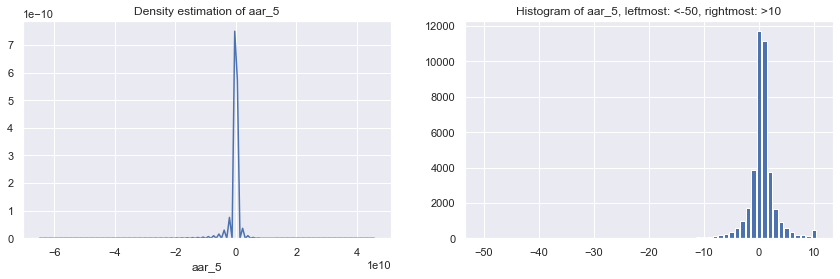

aar_5 range: [-64863896415.11076, 45761542196.09154]


In [9]:
visualize.plot_outliers(df)

In [10]:
df = utils.remove_outliers(df, range_min=-50 , range_max = 10)

Removed 515 outliers


We can think of aar_5 as how well the stock did on average in a day during the time-window.<br/>
While it make sense that a stock would drop rapidly, it's unlikely for the opposite to occur, therefore we believe that an assymetrical drop around 0 would make the most sense.

**Get to know the data**

We will go over the features in the data and present it.

In [11]:
visualize.plot_count(df)

,# of smaples,%,% from decrease,% from flat,% from increase
Basic Industries,756,1.9,0.5,2.2,1.5
Capital Goods,2501,6.4,3.2,7.5,4.3
Consumer Durables,1293,3.3,1.8,3.8,2.4
Consumer Non-Durables,1946,5,4.2,5.3,4.4
Consumer Services,3207,8.2,4.9,8.9,7.4
Energy,734,1.9,2.7,1.4,2.9
Finance,22839,58.2,75.4,54.7,61.9
Health Care,823,2.1,1.1,2.1,2.5
Miscellaneous,409,1,0.7,1.1,0.9
Public Utilities,1024,2.6,1.1,2.9,2.5


As shown below we collected dividend announcements from 1998 to 2019. <br/>
An interesting observation is that while the financial sector is 58% of all our samples (table above) it’s 75% of samples with a decrease in dividend – much higher. A reason for that might be that the financial sector is a highly regulated sector. The more regulation, the lower the chance of managers to withhold bad news and since a decrease in dividend is considered as bad news, it might explain why those events are more common in this sector.

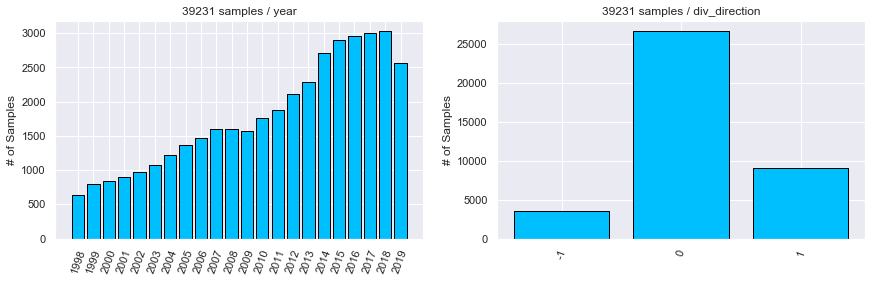

In [12]:
if run_speed < 3:
    visualize.plot_years_change_hist(df)

Another interesting observation is that in 68% of our samples the dividend is flat. This might a raise a challenge – since we try to predict AR and reasoned that a change in the dividend policy is a contributor, it might have less impact when considering the entire sample. In addition, 23% percent of our samples are of increased dividend verses 9% of a decrease. Some of it is explained by about 900 initial announcements (as the number of unique companies) that we classified as an increase. The rest of the gap might be explained by that bad news (decrease) tend to be less common than good new (increase).

**Normalizing the abnormal return**

One more thing we had in mind is to normalize the abnormal return, that's why we created "aar_i%",<br/>
which is the same as "aar_i" but divided by the mean of the expected values:<br/>
$aar\_i\% = \frac{aar\_i}{(\sum_{k=-i}^{i}{expected_k})/(2i+1)}$<br/>
The logic behind this is that we want to 'scale' the mistake - it makes more sense to look at the abnormal return as a fraction of the expected price rather than as an absolute value.<br/>

In the graph below we can see histograms of aar_5% given the direction of the dividend change (increase/decrease/flat). 

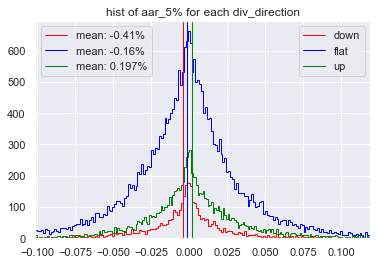

In [13]:
visualize.plot_aar5p_given_dir(df)

We would like to conclude the initial observation by looking at the distribution of aar_5% given the change in dividend direction (above). As expected, the mean of a decreased dividend is the leftmost with a negative AR, the mean of the increased dividend is the right most with a positive AR and the flat is close to 0. The differences seem small, which might indicate non promising results.

We will predict arr_5% instead of aar_5.

**Train/Test Split**<br/>
Before we proceed we will split our data into train and test sets.

In [14]:
df_train, df_test = utils.my_split_test_train(df, test_size = 0.2)

### Step 3: Base line model
This step include two parts:
1. Research replication
2. Run simple linear regression to use as a baseline

Recall we are trying to predict "arr_5", hence we will not use any related features.<br/>
The way the financial ratios were added to the model was based on the 'sector' feature. Therefore is a linear dependency between the 'sector' and 'industry' features to the rest of the financial ratios. In order to avoid avoid instabillity of the model we drop 'sector' and 'industry' features<br/>
Below you can see the features we will use for the baseline prediction.

In [15]:
_ = utils.generate_model_data(df, print_ = True, y_col = 'aar_5%')

Baseline model features: {'year_2003', 'Std Deviation In Prices', 'Fixed Assets/BV of Capital', 'month_2', 'year_2006', 'year_2013', 'year_2014', 'month_6', 'year_2000', 'year_2009', 'MV Debt Ratio', 'year_2001', 'Effective Tax Rate', 'year_2012', 'year_1999', 'month_3', 'year_2017', 'year_2005', 'month_7', 'month_8', 'year_2016', 'month_5', 'month_10', 'month_12', 'year_2011', 'month_11', 'Capital Spending/BV of Capital', 'year_2015', 'alpha', 'beta', 'div_direction', 'year_2007', 'year_2018', 'year_2004', 'month_4', 'div_change', 'year_2008', 'div_amount_num', 'month_9', 'EBITDA/Value', 'year_2010', 'year_2019', 'year_2002', 'BV Debt Ratio', 'quarter'}


**Research replication**<br/>
In order to validate our data and make sure it 'make sense', we will try to replicate previous research results.<br/>
To do so - we would need to drop samples where $div\_change = 0$. Using linear regression they recieved R^2 of about 7%, we will try to replicate it.

In [16]:
#Regression model - Research
research_baseline_model_data = utils.generate_model_data(df, print_ = False, y_col = 'aar_5')
research_baseline_model_data = research_baseline_model_data[research_baseline_model_data['div_direction'] != 0]
_ = regression_models.run_linear_reg(research_baseline_model_data) 

Train data R squared: 0.05810584723270629


First we can see we got close R squared to previous studies.<br/>
The gap might be explained by the fact that previous studies implemented a more strict dividend policy assumption - a dividend change was considered as such only after two consecutive years of staying at the same level.<br/>
The cost of implementing such a strict dividend policy is losing alot of samples.

**Linear regression as baseline**<br/>
Use simple linear regression on our data:

In [17]:
data_train = utils.generate_model_data(df_train, print_ = False, y_col = 'aar_5%')
data_test = utils.generate_model_data(df_test, print_ = False, y_col = 'aar_5%')
bl_model = regression_models.run_linear_reg(data_train, y_col = 'aar_5%')
print("Test R squared: {}".format(regression_models.r_squared(bl_model, data_test, y_col = 'aar_5%')))

Train data R squared: 0.013403887281290605
Test R squared: 0.0029011755602990075


The above result isn't satisfying, in order to get better result we did the following:
1. Where did we do especially bad? (droping 2008 - 2009)
2. Feature engineering 
3. Revisiting the mearsurment assumptions

### Step 4: Analysis of error for the base line model + conclusions (years 2008-2009)
Below are distributions graphs of the baseline model error (the difference between actual aar_5% and the predicted aar_5%).<br/>
The tail is where we did especially bad (marked as red in the right graph).

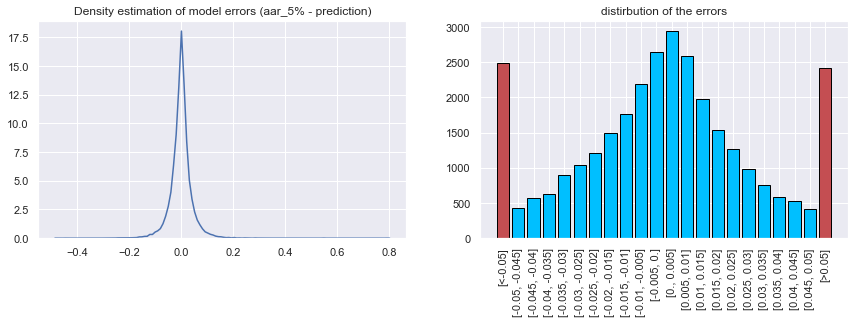

In [18]:
preds = regression_models.predict_linear_reg(bl_model, data_train, y_col = 'aar_5%')
visualize.plot_errors_dist(data_train, preds)

The graph below reveales it was mainly due to the years 2008-2009 

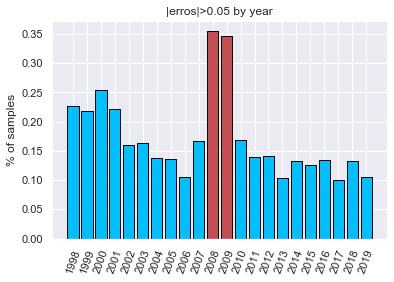

# of samples in year 2008 - 2009: 3170


In [19]:
visualize.plot_error_by_year(df_train, preds)
print("# of samples in year 2008 - 2009: {}".format(df[(df['year']==2008) | (df['year']==2009)].shape[0]))

There are 3170 samples from those years, which we decided to drop as a result of the analysis above.

Run linear regression without 2008 - 2009 samples:

In [20]:
data_train_no0809, year_col_train = utils.generate_model_data(df_train, drop_08_09=True, return_year = True,print_ = False, y_col = 'aar_5%')
data_test_no0809, year_col_test = utils.generate_model_data(df_test, drop_08_09=True, return_year = True,print_ = False, y_col = 'aar_5%')
bl_model_no0809 = regression_models.run_linear_reg(data_train_no0809, y_col = "aar_5%")

Train data R squared: 0.015478312003275096


One more thing we would like to check is that the ratio between the train and the test sets hasn't changed dramaticlly:

In [21]:
print("Test Size / Train Size = {}".format(data_test_no0809.shape[0]/data_train_no0809.shape[0]))

Test Size / Train Size = 0.24981804318441755


Above we can see that it stays ~0.25

### Step 4.1: Feature engineering financial ratios (AsyScore) 

In previous research, they claim the higher the asymmetry in information in market (between firms and investors) the more likely it is for managers to withhold bad news. They further claim that if managers indeed withhold bad news, bad news would have a greater negative impact on AR. We divided our features to those which contribute to high asymmetry and low asymmetry based on the arguments from this research:
* Low MV and BV ratios $\Rightarrow$ High assymetri
* High std.devation in prices $\Rightarrow$ High assymetri
* Technology sector  $\Rightarrow$ High assymetri
* High MV and BV ratios  $\Rightarrow$ Low assymetri
* Regulated sectors  $\Rightarrow$ Low assymetri
* Low std.deviation in prices  $\Rightarrow$ Low assymetri

Further explanation about those desicions in the PDF document.

We will create a single score called AsyScore on a scale of 0 to 1. The higher the asymmetry of a sample, the higher the score. For ech sample we creat `sum` , which is calculated as the summation of (intially `sum = 0`):
* For the MV and BV ratios we add -1 if it's above the yearly mean or 1 if it's below.
* For the std.devation we add 1 if it's above the yearly mean or -1 if it's below.
* For regulated sectors we add -1
* For Technology we add 1

We took the AsyScore to be the `mean(sum)+1` (the `+1` make it non-negative).<br/>
In addition we add `Asy_direction` feature, we is calculated as `AsyScore * div_direction`.<br/>
We will drop all the financial ratios - because we hope that this feature will "catch" their main information.

In [22]:
#predicting aar_1% including delte_%_t-(4,5)
df_asy_train = utils.gen_AsyScore(df_train, drop_fin_ratios = True, add_direction_asy = True)
df_asy_test = utils.gen_AsyScore(df_test, drop_fin_ratios = True, add_direction_asy = True)
data_asy_train = utils.generate_model_data(df_asy_train, drop_08_09=0, print_ = False, y_col = 'aar_5%')
data_asy_test = utils.generate_model_data(df_asy_test, drop_08_09=0,print_ = False, y_col = 'aar_5%')
_= regression_models.run_linear_reg(data_asy_train, y_col = 'aar_5%')

Train data R squared: 0.013215130954286947


In [53]:
#research  - aar_5
df_asy = utils.gen_AsyScore(df[df['div_direction'] != 0])
data_asy = utils.generate_model_data(df_asy, drop_08_09=0, print_ = False, y_col = 'aar_5')
_ = regression_models.run_linear_reg(data_asy, y_col = 'aar_5')

Train data R squared: 0.05734037844224882


We can see that this isn't give us better results.

### Step 5: Revisiting measurment assumptions - Sensitivity analysis (size of window)

The measurment assumption we would like to revisit is the windows size around the annoucement.<br/>
As of now the window size if fixed to five days post and prior to the day of the dividend annoucment. There's a reason to believe that other window size (symmetrical or not) will correspond better with our goal - measuring the abnoraml return (more on that in the PDF documentation).
Below, you can see the average normalized abnormal return ("aar_i%") gived the dividend change direction, for different window sizes.

In [24]:
visualize.window_analysis(feature_handler.create_asymmetric_window(df, -1, 5), 'asy')

,aar_0%,aar_1%,aar_2%,aar_3%,aar_4%,aar_5%,aar_asy-1_5%
down,-0.41,-0.43,-0.43,-0.41,-0.41,-0.41,-0.47
flat,-0.16,-0.16,-0.15,-0.15,-0.14,-0.14,-0.13
up,0.07,0.13,0.15,0.18,0.2,0.21,0.31


From the table above we can see that the rightmost column - the asymmetrical window, shows the most consistent trends with our apriori believes. 

Below we use 5-fold CV to estimate the R^2 in linear regression for each of the window sizes:<br/>
(the "CV mean R squared" is the mean of the R^2 for each unused fold at each iteration)

In [25]:
for ws, y_col in [(1,'aar_1%'),  ((-1,5) ,"aar_asy{}_{}%".format(*(-1,5)))]:
    data_ws1 = utils.generate_model_data(df_asy_train, window_size=ws,
                                                     y_col=y_col,
                                                     drop_08_09 = True,
                                                     print_ = 0)
    print("Window: "+str(ws), end = ', ')
    _ = regression_models.evaluate_Rsq_CV(data_ws1, y_col = y_col)

Window: 1, CV mean R squared: 0.10737517441796392
Window: (-1, 5), CV mean R squared: 0.10013766421871646


Although the results are not promising just yet, them major advantage is that using the new window size let us use more information closer to the announcment time (t-4 and t-5).

We will choose symmetric window around 1 (predicting "aar_1%").
First - in oppose to choosing bigger symmetric window, choosing symmetric windows of size 1 allows us to use the stock price four and five days prior to the dividend announcment date (we need some gap because the way we filled the weekend-empty values might affect the response).
Another reason is that most of our samples are without change in dividend, for those samples, taking a window size too large might be costly in terms of background noises (since no event has happened).

In [26]:
ws, y_col = 1,'aar_1%'
data_ws_train = utils.generate_model_data(df_asy_train, window_size=ws, y_col = y_col,drop_08_09 = True, print_ = 0)
data_ws_test = utils.generate_model_data(df_asy_test, window_size=ws, drop_08_09 = True, print_ = 0)

_ = regression_models.run_linear_reg(data_ws_train, y_col = y_col)

Train data R squared: 0.21007692337928363


### Step 6: Run new model (Regression) (naive + feature handler)

We will consider two new features, since we normalized our response, it's make sense to also normalize in the same way the new features that were added from the window size change.<br/>
$delta\_\%\_{t-5}=\frac{price_{t-5} - expected_{t-5}}{expected_{t-5}}$

$delta\_\%\_{t-4}=\frac{price_{t-4} - expected_{t-4}}{expected_{t-4}}$

In [27]:
ws, y_col = 1,'aar_1%'


data_ws_delta_train = utils.generate_model_data(df_asy_train, window_size=ws, y_col = y_col, delta_precentage = True,
                                                  drop_08_09 = True, print_ = 0)
data_ws_delta_test = utils.generate_model_data(df_asy_test, window_size=ws,y_col = y_col, delta_precentage = True,
                                                 drop_08_09 = True, print_ = 0)

_ = regression_models.run_linear_reg(data_ws_delta_train, y_col = y_col, print_summary=0)

Train data R squared: 0.5155179617931628


Seems like that gave us a big improvment.<br/>
That's raise some thoughts about the importance of the other features, using Recursive Feature Elimination gets $delta\_\%\_{t-4}$ as the highest ranking feature

In [28]:
regression_models.rfe(data_ws_delta_train, y_col, n_features_to_select=1)

{'delta_%_t-4'}

Running linear regression using only 'delta_%_t-4' support this decision:

In [29]:
_ = regression_models.run_linear_reg(data_ws_delta_train[['delta_%_t-4', y_col]],
                                     test_data = data_ws_delta_test[['delta_%_t-4', y_col]], 
                                     y_col = y_col)

Train data R squared: 0.5122205904052293
Test data R squared: 0.45255701207396115


We will issue two points:
* The finnancial explanation behind it - since for most of our samples $div\_direction=0$, it means that 

**#TODO: ANAT**

### Step 7: Run different Regression models and compare
Now we want to leave the linear regression model, and use more complex models.<br/>
First we will split the data into train and test.

In [30]:
X_train, X_test, y_train, y_test = \
data_ws_delta_train.drop([y_col], axis = 1), data_ws_delta_test.drop([y_col], axis = 1),\
data_ws_delta_train[y_col], data_ws_delta_test[y_col],

Next we will introduce new baseline models:<br/>
* The First one will be a simple linear regression, using only the variable 'delta_%_t-4'
* The second one will be a constant model which always predict the mean value of y_train - this model won't be very helpful here, but during the checking of different regression models, many models (espcially MLPRegressor) converged to it, hence we present it too.<br/>

In addition we will now look at the mean squared error instead of the R squared we looked at before. We want to compare models that aren't linear regression. In praticular we will examine the mse*(10^4) because the scale if very small.

In [33]:
lr_features = ['delta_%_t-4']
bl_model_lg, bl_model_const = regression_models.step7_bl_models(X_train, X_test, y_train, y_test, lr_features = lr_features)

Linear Regression model mse*e+4: 10.577994984433456
Linear Regression model mse*e+4: 10.577994984433456
Constant model mse*e+4: 19.32255953892095


We examined few models, such as: MLP Regressor, XGBoost and Random Forest.<br/>
We didn't get better results than our baselines, but we could see that the models that got good results 'converged' to one of the baseline models.<br/>
We decided to first use our linear regression baseline model and then predict it's error:

In [34]:
y_delta_train = y_train - bl_model_lg.predict(X_train[lr_features])
y_delta_test = y_test - bl_model_lg.predict(X_test[lr_features])
X_delta_train = X_train.drop(lr_features, axis = 1)
X_delta_test = X_test.drop(lr_features, axis = 1)

After considering few models, Random Forest gave us the best results.

We will now tune it's hyperparameters, after some rough tuning we saw that the maximum depth and number of trees has the most influence. We will use grid search CV to choose the best combination.<br/>
**Will only run when run_speed == 1, takes more than an hour**

In [42]:
n_est = [10 , 25, 75, 150, 300, 500, 600,800]
depths =  [5, 15, 20, 40, 100]
gcv_1 = utils.rf_cv(X_train, y_delta_train, n_est, depths, run_speed = run_speed, idx = 1)


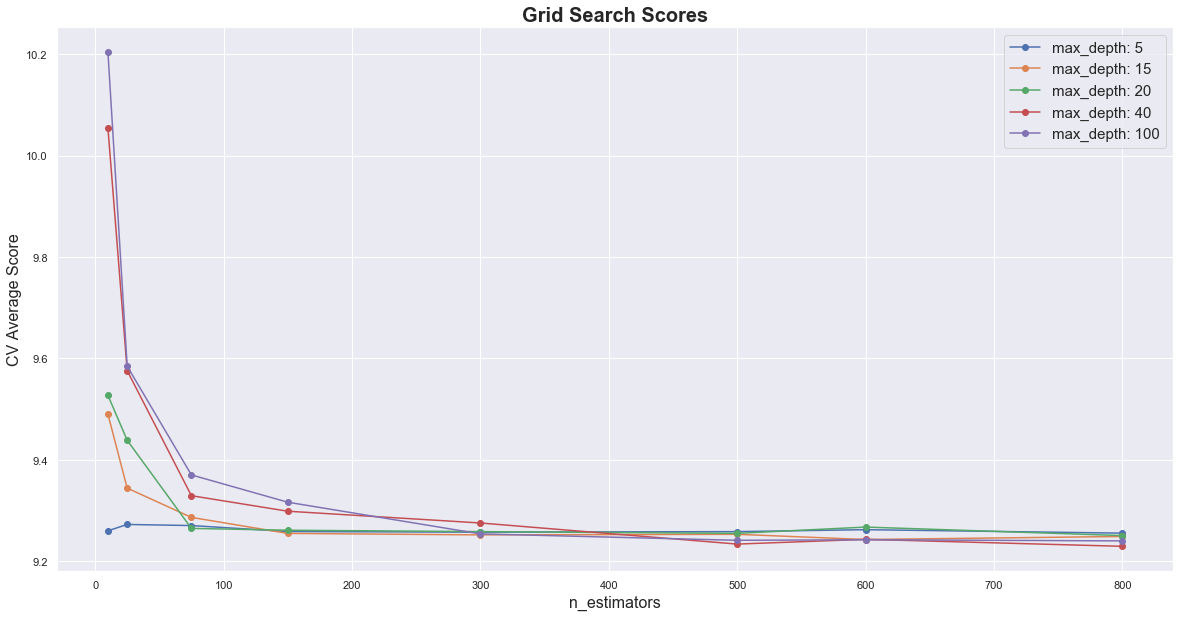

In [43]:
regression_models.plot_grid_search(gcv_1, n_est, depths, 'n_estimators', 'max_depth')

In [44]:
n_est = [600,800, 1000]
depths = [40, 100, 150]

gcv_2 = utils.rf_cv(X_train, y_delta_train, n_est, depths, run_speed = run_speed, idx = 2)

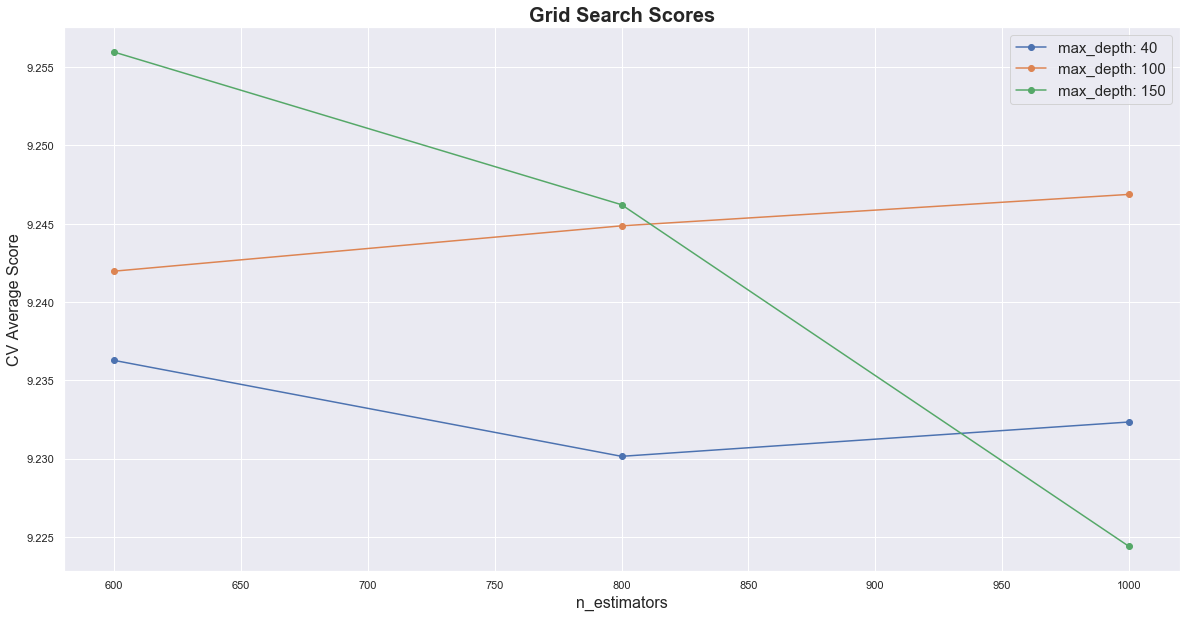

In [45]:
regression_models.plot_grid_search(gcv_2, n_est, depths, 'n_estimators', 'max_depth')

In [46]:
best_params = gcv_2['mean_test_score'].argmin()
gcv_2['params'][best_params]

{'max_depth': 150, 'n_estimators': 1000}

We can see that choosing depth to be 150 and 1000 trees gives the best result.<br/>
We will train our model on the whole train set and than evaluate it on the test set.<br/>
The train time of the model takes about 15 minutes. If you would like to skip it please change skip to True in the cell below.

In [47]:
#READ WARNING BELOW
skip = False

**WARNING: Using `skip = True` will only produce valid score if the notebook was run by it's order and with the default seed (`seed = 10`)**<br/>(we didn't save the model itself because it takes ~2GB memory, instead we saved the predictions)

In [48]:
if skip:
    with open('notebook_files/step7_predictions', 'rb') as file:
        predictions = pickle.load(file)
else:
    rf_model = utils.fit_random_forest(X_train, y_delta_train, n_estimators = 1000, max_depth = 150)
    predictions = rf_model.predict(X_test) + bl_model_lg.predict(X_test[['delta_%_t-4']])

print("Total mse using lr+rf: {}".format(regression_models.mse(predictions, y_test)))

Total mse using lr+rf: 10.1854238517866


We can see that the mse improved to about 10.2, that's not a big improvment.

### Step 8: Discrete Models

Explain what we did

In [49]:
X_bucket_train =  X_train[['delta_%_t-4']]
X_bucket_test =  X_test[['delta_%_t-4']]

y_bucket_train = y_train.apply(discrete_models.bucket_assignment)
y_bucket_test = y_test.apply(discrete_models.bucket_assignment)

Choose best K

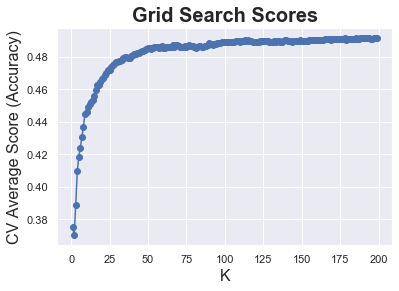

In [50]:
knn_gcv = discrete_models.knn_choose_K(X_bucket_train, y_bucket_train, [i for i in range(1, 200)])

In [51]:
K = 100
knn_model = discrete_models.run_knn(X_bucket_train, X_bucket_test, y_bucket_train, y_bucket_test, K)

Test Accuracy: 0.49458934517203107


In [52]:
discrete_models.knn_tables(knn_model, X_bucket_test, y_bucket_test)

Absolute values:			Percentage values:


Test - Distribution 
 
 
 pred_bucket 
 -2 
 -1 
 0 
 1 
 2 
 All 
 
 
 bucket 
 
 
 
 
 
 
 
 
 
 
 -2 
 937 
 294 
 141 
 87 
 41 
 1500 
 
 
 -1 
 274 
 551 
 339 
 174 
 70 
 1408 
 
 
 0 
 105 
 350 
 755 
 295 
 79 
 1584 
 
 
 1 
 71 
 178 
 321 
 570 
 247 
 1387 
 
 
 2 
 54 
 65 
 145 
 313 
 752 
 1329 
 
 
 All 
 1441 
 1438 
 1701 
 1439 
 1189 
 7208 
 
 
 
 
 
 
 Test - Distribution 
 
 
 pred_bucket 
 -2 
 -1 
 0 
 1 
 2 
 All 
 
 
 bucket 
 
 
 
 
 
 
 
 
 
 
 -2 
 62.47 
 19.60 
 9.40 
 5.80 
 2.73 
 100.00 
 
 
 -1 
 19.46 
 39.13 
 24.08 
 12.36 
 4.97 
 100.00 
 
 
 0 
 6.63 
 22.10 
 47.66 
 18.62 
 4.99 
 100.00 
 
 
 1 
 5.12 
 12.83 
 23.14 
 41.10 
 17.81 
 100.00 
 
 
 2 
 4.06 
 4.89 
 10.91 
 23.55 
 56.58 
 100.00 
 
 
 All 
 19.99 
 19.95 
 23.60 
 19.96 
 16.50 
 100.00

### Step 9: Conclusions

Our goal in this project was to predict abnormal return as a result of a dividend announcement. Our main finding suggests that when dividends do not change versus previous announcement, changes in the AR are mainly due to inaccuracies in the pricing expectation model. 

Modeling these inaccuracies helped us achieve R^2 of approximately 50%. In addition, by recognizing it as the main feature we were able to consider other models such as combining linear regression with random forest or turning our problem to a discrete one and using KNN. <br/>
Our focal point in this project was a complex problem setting. What made our problem setting complex is the need to integrate financial theory throughout the data science workflow, which we believe we did.


The opportunity to predict AR can contribute decision making. Think of a scenario in which a firm is facing a choice of whether it should announce a dividend or re-invest the resources in on-going operations. Assume the firm is maximizing its market value. As we showed, changing the dividend policy impacts the AR and should be a factor to consider when estimating the attractiveness of the re-investment. 
